In [1]:
import os
import pickle
import random
import glob
import datetime
import pandas as pd
import numpy as np
import cv2
import pydicom
from tqdm import tqdm
from joblib import delayed, Parallel
import zipfile
from pydicom.filebase import DicomBytesIO
import sys
from PIL import Image
import cv2
#from focal_loss import sparse_categorical_focal_loss
import keras
#import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D, Dropout
from keras.applications.inception_v3 import InceptionV3

# importing pyplot and image from matplotlib 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
from keras.optimizers import SGD
from keras import backend
from keras.models import load_model

from keras.preprocessing import image
import albumentations as A


from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import tensorflow as tf

Using TensorFlow backend.


In [2]:
from tensorflow.keras.losses import Reduction

from tensorflow_addons.losses import SigmoidFocalCrossEntropy

In [3]:
base_url = '/home/ubuntu/kaggle/rsna-intracranial-hemorrhage-detection/'
TRAIN_DIR = '/home/ubuntu/kaggle/rsna-intracranial-hemorrhage-detection/stage_2_train/'
TEST_DIR = '/home/ubuntu/kaggle/rsna-intracranial-hemorrhage-detection/stage_2_test/'
image_dir = '/home/ubuntu/kaggle/rsna-intracranial-hemorrhage-detection/png/train/adjacent-brain-cropped/'
save_dir = 'home/ubuntu/kaggle/models/'
os.listdir(base_url)

def png(image): 
    return image + '.png'

# Learning rate

In [4]:
initial_learning_rate = 1e-2
first_decay_steps = 1000
lr_decayed_fn = (
  tf.keras.experimental.CosineDecayRestarts(
      initial_learning_rate,
      first_decay_steps))
opt = tf.keras.optimizers.SGD(learning_rate=lr_decayed_fn, nesterov=True)

# Undersampling

In [5]:
def undersample(dataframe,steps,batch_size):
        part = np.int(steps/3 * batch_size)
        zero_ids = np.random.choice(dataframe.loc[dataframe["any"] == 0].index.values, size=2*part, replace=False)
        hot_ids = np.random.choice(dataframe.loc[dataframe["any"] == 1].index.values, size=1*part, replace=False)
        data_ids = list(set(zero_ids).union(hot_ids))
        np.random.shuffle(data_ids)
        return data_ids
        

In [7]:
train_indices = undersample(training_data, 8050,32)
print(len(train_indices))

valid_indices = undersample(validation_data, 2010,32)
print(len(valid_indices))

257598
64320


In [8]:
l = training_data[training_data.index.isin(train_indices)]
m = validation_data[validation_data.index.isin(valid_indices)]

# Generator

In [6]:
train_idg = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        shear_range=0.05,
        rotation_range=50, # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,
        rescale=1./255)
valid_idg = ImageDataGenerator(rescale=1./255)
training_data = pd.read_csv(f'train_2.csv') 
training_data['Image'] = training_data['Image'].apply(png)

validation_data = pd.read_csv(f'valid_2.csv')
validation_data['Image'] = validation_data['Image'].apply(png)

columns=['any','epidural','intraparenchymal','intraventricular', 'subarachnoid','subdural']

#train_data_generator = train_idg.flow_from_dataframe(training_data, directory = image_dir,
#                           x_col = "Image", y_col = columns,batch_size=64,
#                           class_mode="raw", target_size=(224,224), shuffle = True)
#valid_data_generator  = valid_idg.flow_from_dataframe(validation_data, directory = image_dir,
#                        x_col = "Image", y_col = columns,batch_size=64,
#                        class_mode = "raw",target_size=(224,224), shuffle = False)

In [9]:
train_under_generator = train_idg.flow_from_dataframe(l, directory = image_dir,
                           x_col = "Image", y_col = columns,batch_size=64,
                           class_mode="raw", target_size=(224,224), shuffle = True)
valid_under_generator  = valid_idg.flow_from_dataframe(m, directory = image_dir,
                        x_col = "Image", y_col = columns,batch_size=64,
                        class_mode = "raw",target_size=(224,224), shuffle = False)

Found 257598 validated image filenames.
Found 64320 validated image filenames.


# Model

In [40]:
from tensorflow.keras.applications.resnet50 import ResNet50


base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
print('Model loaded.')


base_model.summary()

Model loaded.
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_____________________________________________________________________________

In [41]:
#define the dictionary of layers
layer_dict = dict([(layer.name, layer) for layer in base_model.layers])
print(layer_dict)

{'input_5': <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f31cf5bc978>, 'conv1_pad': <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f2e072d6ac8>, 'conv1_conv': <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2e072d6748>, 'conv1_bn': <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f2e072d6ba8>, 'conv1_relu': <tensorflow.python.keras.layers.core.Activation object at 0x7f2e072cb3c8>, 'pool1_pad': <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f2e072cb1d0>, 'pool1_pool': <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f2e072d6a90>, 'conv2_block1_1_conv': <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2e0726a8d0>, 'conv2_block1_1_bn': <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f2e07280710>, 'conv2_block1_1_relu': <tensorflow.python.keras.layers.core.Activation object at 0x7f2e072835c0>, 'conv

In [10]:
from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow as tf
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, MaxPooling2D

METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc')
      
]


# create the base pre-trained model

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
print('Model loaded.')


# add a global spatial average pooling layer
x = base_model.output
#net = MaxPooling2D(pool_size= (2,2), strides=(2,2),padding='same', name='pool')(x)
x = GlobalAveragePooling2D()(x)
net = Dense(256, activation='elu')(x)
net = Dense(6, activation='sigmoid')(net)


# this is the model we will train
model = Model(inputs=base_model.input, outputs=net)



# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
#for layer in base_model.layers:
#    layer.trainable = False
for layer in base_model.layers[:20]:
    layer.trainable = False


# compile the model (should be done *after* setting layers to non-trainable)
model.compile(opt, loss='binary_crossentropy', metrics=METRICS)




model.summary()

Model loaded.
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_________________________________________________________________________

# Callbacks

In [11]:
from keras import backend as K

from tensorflow.keras.callbacks import ModelCheckpoint


checkpoint = tf.keras.callbacks.ModelCheckpoint('/kaggle/models/resnet50_{epoch:08d}.h5', period=1,mode= 'auto',save_best_only=True) 

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callback_list = [checkpoint]


In [12]:
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [13]:
class_weight = {0:1.0,1:2.0}
class_weight

{0: 1.0, 1: 2.0}

In [14]:



num_epochs = 20

batch_size = 512
training_steps = len(training_data) // batch_size
validation_step = len(validation_data) // batch_size





# FIT THE MODEL
history = model.fit(train_under_generator,
            epochs=num_epochs,
            steps_per_epoch=training_steps,
            callbacks=callback_list,
            class_weight=class_weight,
            validation_data=valid_under_generator,
            validation_steps= validation_step
                   ) 





tf.keras.backend.clear_session()


/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/20
1174/1174 [==============================] - 1391s 1s/step - loss: 0.2594 - tp: 20654.0000 - fp: 9043.0000 - tn: 382349.0000 - fn: 38758.0000 - accuracy: 0.8940 - precision: 0.6955 - recall: 0.3476 - auc: 0.8806 - val_loss: 0.2366 - val_tp: 5432.0000 - val_fp: 1566.0000 - val_tn: 97069.0000 - val_fn: 9213.0000 - val_accuracy: 0.9048 - val_precision: 0.7762 - val_recall: 0.3709 - val_auc: 0.9059
Epoch 2/20
1174/1174 [==============================] - 1331s 1s/step - loss: 0.2218 - tp: 28663.0000 - fp: 9257.0000 - tn: 381888.0000 - fn: 31008.0000 - accuracy: 0.9107 - precision: 0.7559 - recall: 0.4804 - auc: 0.9158 - val_loss: 0.2169 - val_tp: 6330.0000 - val_fp: 1611.0000 - val_tn: 97024.0000 - val_fn: 8315.0000 - val_accuracy: 0.9124 - val_precision: 0.7971 - val_recall: 0.4322 - val_auc: 0.9211
Epoch 3/20
1174/1174 [==============================] - 1321s 1s/step - loss: 0.2120 - tp: 30740.0000 - fp: 9266.0000 - tn: 381850.0000 - fn: 28960.0000 - accuracy: 0.9152 - precisio

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1174/1174 [==============================] - 1262s 1s/step - loss: 0.1660 - tp: 38304.0000 - fp: 7803.0000 - tn: 383484.0000 - fn: 21225.0000 - accuracy: 0.9356 - precision: 0.8308 - recall: 0.6435 - auc: 0.9534 - val_loss: 0.1679 - val_tp: 8816.0000 - val_fp: 1277.0000 - val_tn: 97358.0000 - val_fn: 5829.0000 - val_accuracy: 0.9373 - val_precision: 0.8735 - val_recall: 0.6020 - val_auc: 0.9517
Epoch 13/20
1174/1174 [==============================] - 1261s 1s/step - loss: 0.1656 - tp: 38180.0000 - fp: 7795.0000 - tn: 383731.0000 - fn: 21098.0000 - accuracy: 0.9359 - precision: 0.8305 - recall: 0.6441 - auc: 0.9533 - val_loss: 0.1928 - val_tp: 7663.0000 - val_fp: 1029.0000 - val_tn: 97606.0000 - val_fn: 6982.0000 - val_accuracy: 0.9293 - val_precision: 0.8816 - val_recall: 0.5233 - val_auc: 0.9404
Epoch 14/20
1174/1174 [==============================] - 1261s 1s/step - loss: 0.1677 - tp: 38316.0000 - fp: 8001.0000 - tn: 383120.0000 - fn: 21379.0000 - accuracy: 0.9348 - precision: 0.8273

# Evalution

In [15]:
valid_predict =  model.evaluate_generator(valid_under_generator)
print(valid_predict)

Instructions for updating:
Please use Model.evaluate, which supports generators.
[0.1642387956380844, 31638.0, 4437.0, 330987.0, 18858.0, 0.9396376013755798, 0.8770062327384949, 0.6265446543693542, 0.9554124474525452]


In [16]:
model.metrics_names

['loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc']

In [17]:
print('\n---------------\n')
print('validation data **loss** value =', valid_predict[0])
print('\n---------------\n')
print('validation data **true positive** value = ', valid_predict[1])
print('\n---------------\n')
print('validation data **false positive** value =', valid_predict[2])
print('\n---------------\n')
print('validation data **true negative** value =', valid_predict[3])
print('\n---------------\n')
print('validation data **false negative** value =', valid_predict[4])
print('\n---------------\n')
print('validation data **accuracy** value = ', valid_predict[5])
print('\n---------------\n')
print('validation data **precision** value =', valid_predict[6])
print('\n---------------\n')
print('validation data **recall* value =', valid_predict[7])
print('\n---------------\n')
print('validation data **AUC* value =', valid_predict[8])
print('\n---------------\n')


---------------

validation data **loss** value = 0.1642387956380844

---------------

validation data **true positive** value =  31638.0

---------------

validation data **false positive** value = 4437.0

---------------

validation data **true negative** value = 330987.0

---------------

validation data **false negative** value = 18858.0

---------------

validation data **accuracy** value =  0.9396376013755798

---------------

validation data **precision** value = 0.8770062327384949

---------------

validation data **recall* value = 0.6265446543693542

---------------

validation data **AUC* value = 0.9554124474525452

---------------



In [35]:
y_true = m[['any','epidural','intraparenchymal','intraventricular', 'subarachnoid','subdural']].reset_index(drop=True)

#Y_pred = model.predict_generator(valid_under_generator)
preds = np.where(Y_pred < 0.25, 0, 1)



#val = 0.25

#Y_pred[Y_pred>=val]=1
#Y_pred[Y_pred<val]=0

# Classification

In [36]:
print('Classification Report')
target_names = ['any','epidural','intraparenchymal','intraventricular', 'subarachnoid','subdural']
print(classification_report(y_true, preds, target_names=target_names))

Classification Report
                  precision    recall  f1-score   support

             any       0.86      0.83      0.84     21440
        epidural       0.34      0.09      0.14       626
intraparenchymal       0.74      0.77      0.75      7306
intraventricular       0.77      0.81      0.79      4894
    subarachnoid       0.61      0.62      0.61      6808
        subdural       0.72      0.61      0.66      9422

       micro avg       0.77      0.74      0.75     50496
       macro avg       0.67      0.62      0.63     50496
    weighted avg       0.77      0.74      0.75     50496
     samples avg       0.25      0.24      0.24     50496



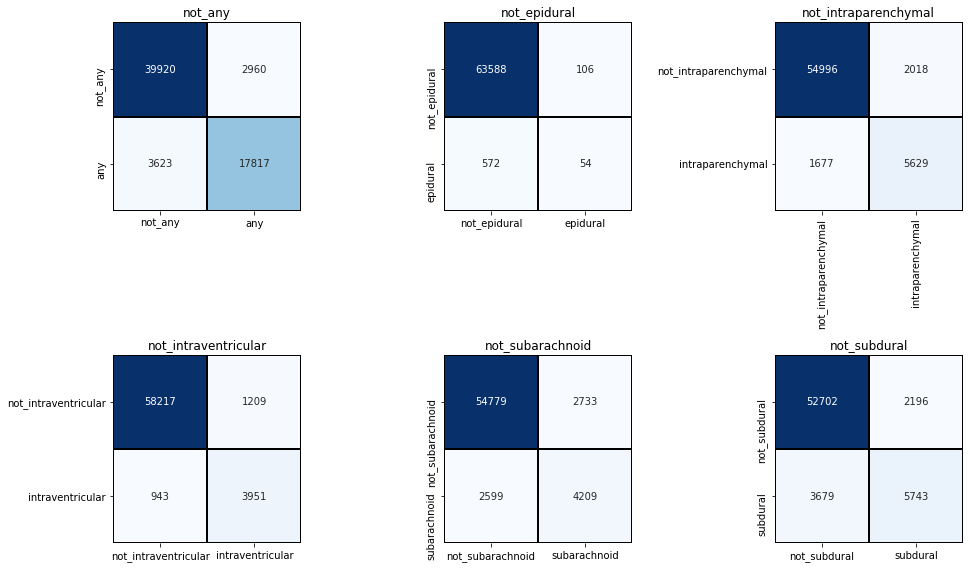

In [37]:
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix
# Creating multilabel confusion matrix
confusion = multilabel_confusion_matrix(y_true, preds)
mlb= ['any','epidural','intraparenchymal','intraventricular', 'subarachnoid','subdural']
# Plot confusion matrix 
fig = plt.figure(figsize = (14, 8))
for i, (label, matrix) in enumerate(zip(mlb, confusion)):
    plt.subplot(f'23{i+1}')
    labels = [f'not_{label}', label]
    sns.heatmap(matrix, annot = True, square = True, fmt = 'd', cbar = False, cmap = 'Blues', 
                xticklabels = labels, yticklabels = labels, linecolor = 'black', linewidth = 1)
    plt.title(labels[0])

plt.tight_layout()
plt.show()

# AUC_ROC_SCORE

In [38]:
auc = roc_auc_score(y_true, preds)
print(auc)

0.7924062612813562


# ACCURACY and LOSS

In [22]:
def plot_training(H):
    # construct a plot that plots and saves the training history
    with plt.xkcd():
        plt.figure(figsize = (10,10))
        plt.plot(H.epoch,H.history["accuracy"], label="train_acc")
        plt.plot(H.epoch,H.history["val_accuracy"], label="val_acc")
        plt.plot(H.epoch,H.history["loss"], label="train_loss")
        plt.plot(H.epoch,H.history["val_loss"], label="val_loss")
        plt.title("Training Accuracy and Loss")
        plt.xlabel("Epoch #")
        plt.ylabel("Accuracy/Loss")
        plt.legend(loc="lower left")
        plt.show()

findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.
findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


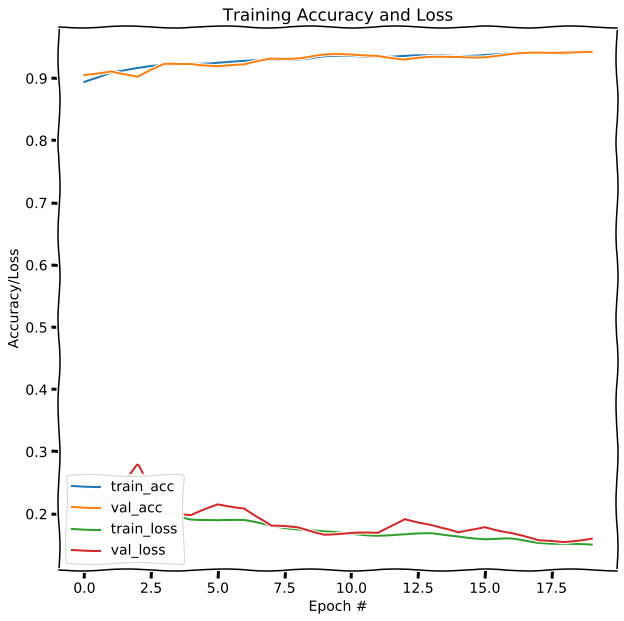

In [23]:
plot_training(history)

In [29]:
from sklearn.utils import class_weight

list_classes = ['any','epidural','intraparenchymal','intraventricular', 'subarachnoid','subdural']
y = l[list_classes].values
sample_weights = class_weight.compute_sample_weight('balanced', y)

In [30]:
sample_weights.shape

(257598,)